In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numba

plt.rcParams["font.size"] = 16

In [2]:
A = np.array([-200, -100, -170, 15])
a = np.array([-1, -1, -6.5, 0.7])
b = np.array([0, 0, 11, 0.6])
c = np.array([-10, -10, -6.5, 0.7])
x0 = np.array([1, 0, -0.5, -1])
y0 = np.array([0, 0.5, 1.5, 1])

@numba.njit
def mullerBrown(x, y):
    zi = A * np.exp(a * (x - x0)**2 + b * (x - x0) * (y - y0) + c * (y - y0)**2)
    return np.sum(zi)

def generate_muller_brown_dataset(N, x_range=(-1.5, 1.5), y_range=(-0.7, 2.0)):
    """
    Generates a dataset of grid points with Müller-Brown potential values.

    Parameters:
    - N (int): Number of points along each axis (total points will be N*N).
    - x_range (tuple): The range (min, max) for the x-axis. Default is (-1.5, 1.5).
    - y_range (tuple): The range (min, max) for the y-axis. Default is (-0.7, 0.7).

    Returns:
    - X (numpy.ndarray): 2D array of x-coordinates with shape (N, N).
    - Y (numpy.ndarray):}2D array of y-coordinates with shape (N, N).
    - Z (numpy.ndarray): 2D array of potential values with shape (N, N).
    """
    # Define Müller-Brown potential parameters


    # Create a grid of x and y values
    x = np.linspace(x_range[0], x_range[1], N)
    y = np.linspace(y_range[0], y_range[1], N)
    X, Y = np.meshgrid(x, y)

    # Initialize the potential with zeros
    Z = np.zeros_like(X)

    # Compute the Müller-Brown potential for each component
    for i in range(4):
        exponent = a[i] * (X - x0[i])**2 + b[i] * (X - x0[i])*(Y-y0[i]) + c[i] * (Y - y0[i])**2
        Z += A[i] * np.exp(exponent)

    return X, Y, Z


def plot_muller_brown_heatmap(trj, temperatures, vmin=-150, vmax=300):
    """
    Plots N subplots of the Müller-Brown potential heatmap with N different trajectories.

    Parameters:
    - trj (numpy.ndarray): Trajectories array of shape (N, T, 2)
    - temperatures (list): List of temperatures corresponding to each trajectory
    - vmin (float): Minimum value for color scaling. Default is -150.
    - vmax (float): Maximum value for color scaling. Default is 300.
    """
    
    N_grid = 500  # Grid size for higher resolution heatmap
    X, Y, Z = generate_muller_brown_dataset(N_grid, y_range=(-1.0, 3.0), x_range=(-2.0, 1.5))
    
    N = trj.shape[0]  # Number of trajectories

    # Determine the number of rows and columns for subplots
    if N == 1:
        nrows, ncols = 1, 1
    elif N == 2:
        nrows, ncols = 1, 2
    elif N <= 4:
        nrows, ncols = 2, 2
    else:
        nrows, ncols = 2, 3

    # Create figure without constrained_layout
    fig = plt.figure(figsize=(ncols * 6, nrows * 5))
    gs = gridspec.GridSpec(nrows, ncols + 1, width_ratios=[1]*ncols + [0.05], wspace=0.3, hspace=0.3)

    axes = []

    for i in range(nrows * ncols):
        if i < N:
            ax = fig.add_subplot(gs[i // ncols, i % ncols])
            axes.append(ax)
        else:
            # Create an empty axis and hide it
            ax = fig.add_subplot(gs[i // ncols, i % ncols])
            ax.axis('off')

    for i in range(N):
        ax = axes[i]
        extent = [X.min(), X.max(), Y.min(), Y.max()]
        im = ax.imshow(Z, extent=extent, origin='lower', cmap='cividis',
                       aspect='auto', vmin=vmin, vmax=vmax)
        ax.scatter(trj[i, :, 0], trj[i, :, 1], s=1, c='red')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')        
        ax.text(0.95, 0.95, f'T={temperatures[i]}',
                color='red', fontsize=20,
                ha='right', va='top',
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))


    # Create colorbar in the last column
    cbar_ax = fig.add_subplot(gs[:, -1])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Potential U(x, y)')

    plt.show()



In [3]:
@numba.njit
def monteCarlo(temperatures, numberOfCycles, parallelTemperingProbability=0.0, maxDisplacement=0.1):
    numberOfSystems = len(temperatures)
    positions = np.zeros((numberOfCycles, numberOfSystems, 2))
    energies = np.zeros((numberOfCycles, numberOfSystems))
    betas = [1/T for T in temperatures]
    
    # very arbitrary rule to get the translation acc to even out
    displacements = [np.sqrt(T) * maxDisplacement for T in temperatures]
    
    acc = np.zeros((numberOfSystems))
    ptAcc = np.zeros((numberOfSystems - 1, 2))
    
    minimum = np.array([-0.557114228, 1.44889779])
    positions[0] = np.repeat(minimum, numberOfSystems).reshape(2, numberOfSystems).T
        
    for system in range(numberOfSystems):
        energies[0, system] = mullerBrown(positions[0, system, 0], positions[0, system, 1])
        
    for cycle in range(1, numberOfCycles):
        for system in range(numberOfSystems):
            newPosition = positions[cycle - 1, system] + displacements[system] * (np.random.rand(2) - 0.5)
            newEnergy = mullerBrown(newPosition[0], newPosition[1])
            if np.random.rand() < np.exp(-betas[system] * (newEnergy - energies[cycle - 1, system])):
                positions[cycle, system] = newPosition
                energies[cycle, system] = newEnergy
                acc[system] += 1
            else:
                positions[cycle, system] = positions[cycle - 1, system]
                energies[cycle, system] = energies[cycle - 1, system]
        
        if np.random.rand() < parallelTemperingProbability:
            systemA = np.random.randint(0, numberOfSystems - 1)
            systemB = systemA + 1
            ptAcc[systemA, 0] += 1
            if np.random.rand() < np.exp((betas[systemB] - betas[systemA]) * (energies[cycle, systemB] - energies[cycle, systemA])):
                ptAcc[systemA, 1] += 1
                tmp =  positions[cycle, systemB]
                positions[cycle, systemA] = positions[cycle, systemB]
                positions[cycle, systemA] = tmp
                
                tmp =  energies[cycle, systemB]
                energies[cycle, systemA] = energies[cycle, systemB]
                energies[cycle, systemA] = tmp
                
        
    print(acc / numberOfCycles)
    if parallelTemperingProbability > 0.0:
        print(ptAcc[:, 1] / ptAcc[:, 0])
    return positions

In [4]:
temperatures = [0.5, 2.0, 5.0, 12.0]
numberOfCycles = int(2e7)

[0.44488835 0.44714995 0.4522744  0.4709547 ]


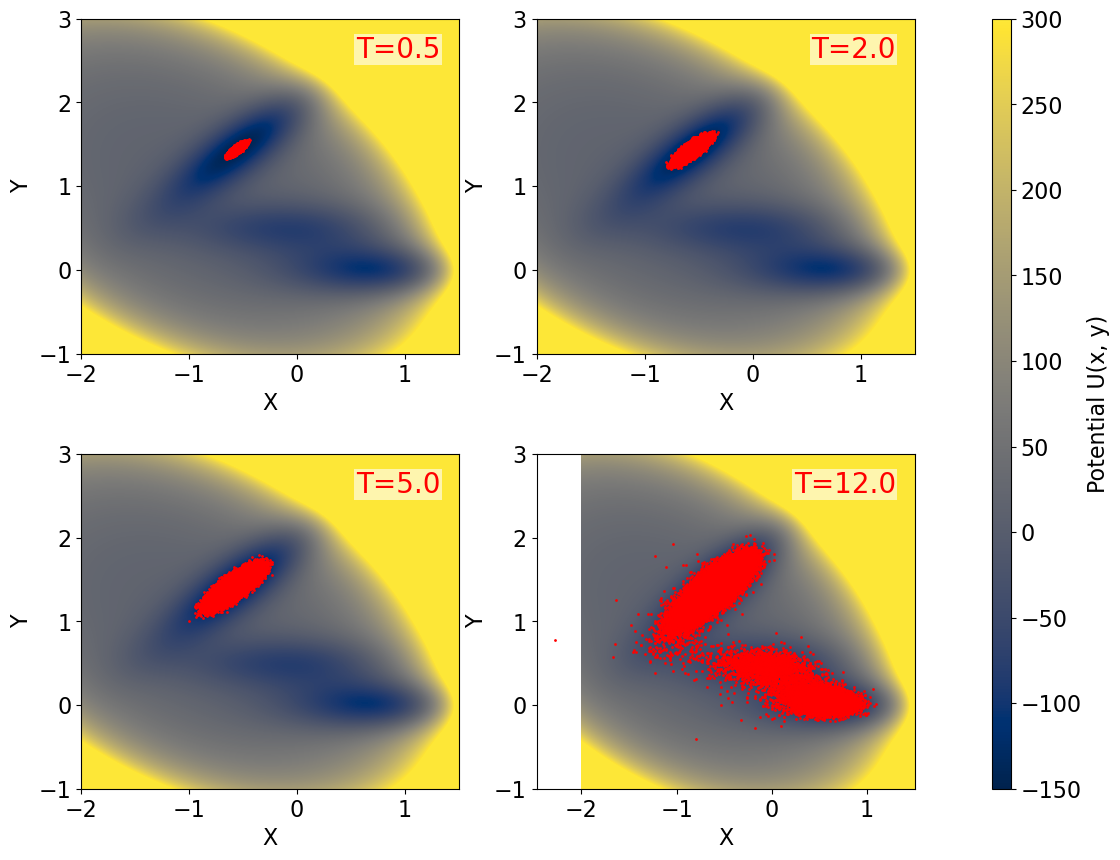

In [5]:
pos = monteCarlo(temperatures,  numberOfCycles, parallelTemperingProbability=0.0)
pos = np.moveaxis(pos[::100], 0, 1)
plot_muller_brown_heatmap(pos, temperatures)

[0.44520495 0.44772805 0.4540855  0.4695921 ]
[0.40095739 0.54856918 0.57770558]


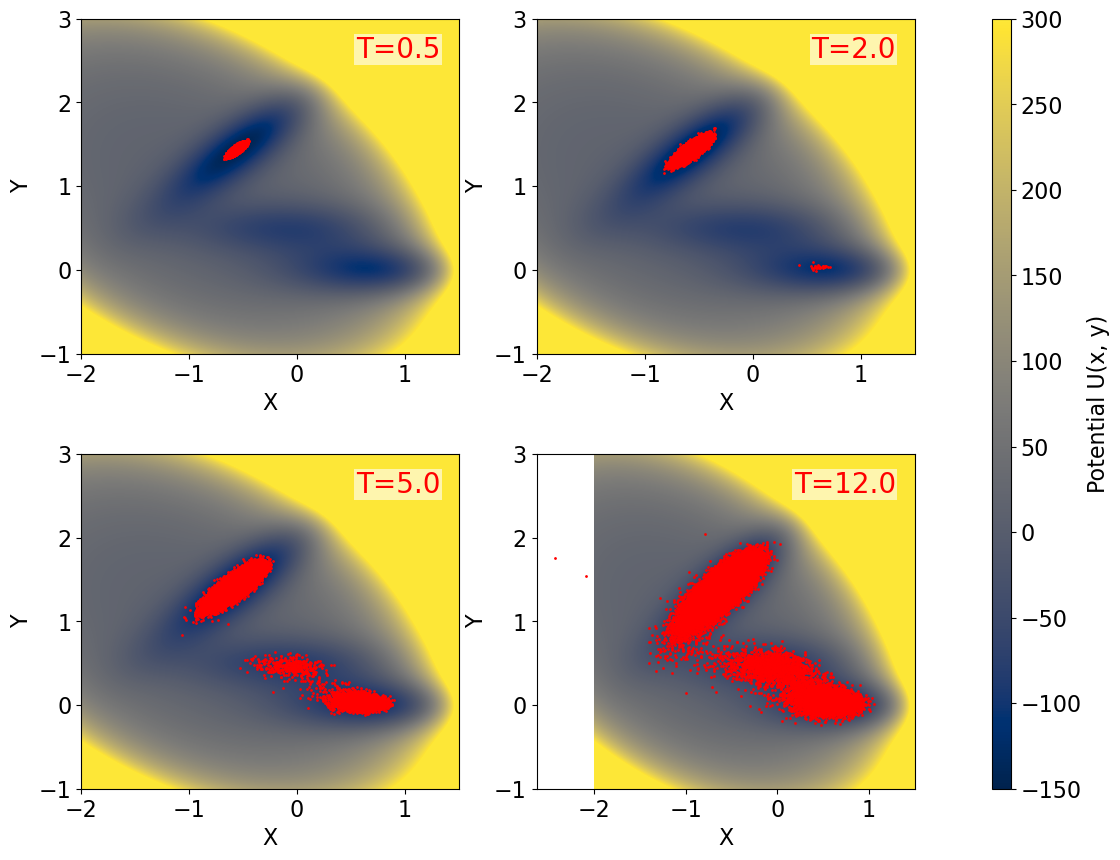

In [6]:
pos = monteCarlo(temperatures,  numberOfCycles, parallelTemperingProbability=0.5)
pos = np.moveaxis(pos[::100], 0, 1)
plot_muller_brown_heatmap(pos, temperatures)